0 ./images/db/train/cars/2539497709_756f025f62.jpg
0 ./images/db/train/cars/2847324790_6dd07ffb54.jpg
0 ./images/db/train/cars/1137646735_2fb2752249.jpg
0 ./images/db/train/cars/car001.jpg
0 ./images/db/train/cars/car003.jpg
0 ./images/db/train/cars/car002.jpg
1 ./images/db/train/flowers/astra04.jpg
1 ./images/db/train/flowers/3826419553_c00dc0e91c.jpg
1 ./images/db/train/flowers/2682530432_e470494b40.jpg
1 ./images/db/train/flowers/0106476_1.jpg
1 ./images/db/train/flowers/marcinki.jpg
1 ./images/db/train/flowers/ANBL.jpg
2 ./images/db/train/faces/3573927657_df093bae27.jpg
2 ./images/db/train/faces/397642272_cedf622248_z.jpg
2 ./images/db/train/faces/61060671.jpg
2 ./images/db/train/faces/face.jpg
2 ./images/db/train/faces/img_1577_crazy-face.jpg
2 ./images/db/train/faces/face2.jpg
2 ./images/db/train/faces/images.jpg
2 ./images/db/train/faces/3775982780_d5ea306ce6.jpg
20


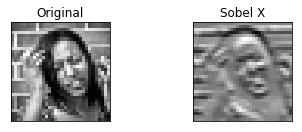

In [2]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


device = torch.device('cpu')


nn_img_size = 32
nn_img_size_half = 16
num_classes = 3

# load and resize train images in three categories
# cars = 0, flowers = 1, faces = 2 ( true_ids )
train_images_cars = glob.glob('./images/db/train/cars/*.jpg')
train_images_flowers = glob.glob('./images/db/train/flowers/*.jpg')
train_images_faces = glob.glob('./images/db/train/faces/*.jpg')
# train_images_faces = glob.glob('./data/train/*.png')
train_images = [train_images_cars, train_images_flowers, train_images_faces]
# train_images = [train_images_faces]
num_rows = len(train_images_cars)+len(train_images_flowers) +len(train_images_faces)
X_train = np.zeros((num_rows, nn_img_size*nn_img_size))
Y_train = np.zeros((num_rows, nn_img_size*nn_img_size))

counter = 0
for (label, fnames) in enumerate(train_images):
    for fname in fnames:
        print(label, fname)
        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (nn_img_size, nn_img_size) , interpolation=cv2.INTER_AREA)
        sobelx = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3, borderType=cv2.BORDER_REPLICATE)
        img = img/ 255.0
        sobelx = sobelx / 255.0

        X_train[counter] = img.flatten()
        Y_train[counter] = sobelx.flatten()
        counter += 1

print(counter)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.show()



In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=(1,1))
        
    def forward(self, x):
        x = torch.tanh(self.conv(x))
        return x

train_data = []
train_target = []
for i in range(X_train.shape[0]-1):
    d = torch.from_numpy(X_train[i].reshape(32, 32))
    d = Variable(d.float())
    d = d.view(1,1,32,32)
    t = torch.from_numpy(Y_train[i])
    t = Variable(t.float())
    t = t.view(1,1,32,32)

    train_data.append(d)
    train_target.append(t)

num_epochs = 50000
batch_size = 1
learning_rate = 0.02

model = Autoencoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.002)

for epoch in range(num_epochs):
    
    sample_indices = np.random.choice(np.arange(len(train_data)), batch_size)
    X_batch = []
    Y_batch = []
    for i in sample_indices:
        X_batch.append(train_data[i])
        Y_batch.append(train_target[i])
        
    for i, data in enumerate(X_batch):
        data = Variable(data.float())
        target = Variable(Y_batch[i].float())
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss < 0.1:
            break
        # ===================log========================
        if epoch % 1000 == 0 and i == 0:
            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, num_epochs, loss.data[0]))
    
print("model weights:", model.conv.weight)


/Users/kristian/anaconda3/envs/lfi/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/50000], loss:0.5915
epoch [1001/50000], loss:0.1966
epoch [2001/50000], loss:0.1563
epoch [4001/50000], loss:0.2002
epoch [6001/50000], loss:0.1916
epoch [7001/50000], loss:0.2521
epoch [9001/50000], loss:0.1531
epoch [10001/50000], loss:0.1939
epoch [16001/50000], loss:0.1200
epoch [17001/50000], loss:0.1554
epoch [18001/50000], loss:0.1012
epoch [22001/50000], loss:0.1653
epoch [23001/50000], loss:0.1292
epoch [24001/50000], loss:0.1003
epoch [25001/50000], loss:0.1531
epoch [29001/50000], loss:0.1523
epoch [30001/50000], loss:0.1554
epoch [31001/50000], loss:0.1318
epoch [35001/50000], loss:0.2550
epoch [38001/50000], loss:0.1218
epoch [40001/50000], loss:0.1277
epoch [41001/50000], loss:0.2435
epoch [44001/50000], loss:0.1529
epoch [45001/50000], loss:0.1900
epoch [47001/50000], loss:0.1288
epoch [48001/50000], loss:0.1938
model weights: Parameter containing:
tensor([[[[-1.0709, -2.1400, -1.0703],
          [ 0.0080,  0.0044,  0.0077],
          [ 1.0870,  2.1581,  1.0887]